In [1]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import slab_tracker_utils as slab
import splits_and_merges as snm
import slab_cross_section_utils as sxs
import slab_workflow
import xarray as xr
from os import walk
import os

import rockhound as rh
from rockhound.slab2 import ZONES
import pygmt
import cartopy.crs as ccrs
%matplotlib inline


In [2]:
def calcualte_pressure(density, depth):
    
    '''
    Calculate pressure at a series of points of set depths (km) with designated densities (g/cm3). Assumes 
    gravity is constant (9.8 m/s**2).

    The basic equation we use is:

    pressure = density • gravity • depth (with depth being total depth, or thickness of the layer)


    Parameters
    -----------
    Density: list or array of densities, in g/cm3.
        The collection of densities. Must correspond to each depth.

    Depth: list or array of depths, in km
        The collection of depths (from surface). Must have a corresponding density for each depth.

    Returns
    -------
    Pressure: array of cumulative pressure, in Megapascals.
        The cumulative pressure at each depth point.
    '''
    #set gravity
    g = 9.8
    
    #check if density is a list, if so convert to array
    if isinstance(density, list): 
        density = np.asarray(density)
        
    #check if depth is a list, if so convert to array
    if isinstance(depth, list): 
        depth = np.asarray(depth)

    #convert density to kg/m3
    rho = density * 1000

    #conver density to m
    Z_bot = depth * 1000
    
    #get incremental depths
    layer_thicknesses = np.zeros_like(depth)
    for ind,i in enumerate(Z_bot):
        #we just use the current depth and subtract the previous one from it
        if ind == 0:
            #for the first point we just need index 0
            layer_thicknesses[ind] = Z_bot[ind]
        else:
            #subtract current depth from previous one to get the change (i.e. the thickness of each layer)
            layer_thicknesses[ind] = (Z_bot[ind] - Z_bot[ind-1])

    #we sum the layer thicknesses and corresponding densities, and multiply by gravity to get pressure in pascals
    pressure = np.sum(layer_thicknesses * rho) * g
    #in megapascals
    pressure = pressure * 1e-6

    return pressure

In [3]:
rotation_filename = '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS.rot'

input_topology_filename = ['/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',
                           '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

coastline_polygons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Coastlines/Matthews_etal_GPC_2016_Coastlines.gpmlz'
isochrons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Isochrons/Muller_etal_AREPS_2016_Isochrons.gpmlz'
COBs = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'
#topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)

#topologies for our subduction points
time = 0 

resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)


In [4]:
cross_section_start_points = []
sub_length = []
polarity = []
segments = []
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            #need polarity of subduction zones
            tmp_polarity = slab.find_overriding_and_subducting_plates(shared_sub_segment, 0)
            
            if tmp_polarity is None:
                continue
            
            for segment in shared_sub_segment.get_geometry().get_segments():
                #print(segment.get_start_point().to_lat_lon())
                #print(segment.get_start_point().to_lat_lon()[0])
                #print(segment.get_start_point().to_lat_lon()[1])
                segment_mean_lat = np.mean((segment.get_start_point().to_lat_lon()[0],
                                            segment.get_end_point().to_lat_lon()[0]))
                segment_mean_lon = np.mean((segment.get_start_point().to_lat_lon()[1],
                                            segment.get_end_point().to_lat_lon()[1]))

                cross_section_start_points.append([segment_mean_lat, segment_mean_lon])
                segments.append(segment)
                sub_length.append(segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms)
                polarity.append(tmp_polarity[2])#tessellate
cross_section_start_points = np.asarray(cross_section_start_points)
sub_length = np.asarray(sub_length)

Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


In [5]:
#now to get our cross section start and end points
#angular distance we want to sample our cross section
angular_distance_forwards = np.radians(8)
angular_distance_backwards = np.radians(5)
cross_section_end_points = []
new_cross_section_start_points = []
for index in range(len(cross_section_start_points)):

    #mid point of cross section segment
    mid_point = pygplates.PointOnSphere(cross_section_start_points[index])
    
    #get normal great circle to segment
    normal = segments[index].get_great_circle_normal().to_normalised()
    
    # Get the unnormalised vector along the normal from the mid point
    stage_pole_x, stage_pole_y, stage_pole_z = pygplates.Vector3D.cross(
                                mid_point.to_xyz(), normal).to_xyz()

    #turn vector into a stage pole? i.e. a point on the great cricle
    stage_pole = pygplates.PointOnSphere(
                        stage_pole_x, stage_pole_y, stage_pole_z, normalise=True)

    #normal great circle always to the left of the 
    if polarity[index] == 'Left':
        subducting_normal_reversal = 1
    else:
        subducting_normal_reversal = -1
    #get the rotation of the stage pole using a set angle
    stage_rotation = pygplates.FiniteRotation(stage_pole, angular_distance_forwards * subducting_normal_reversal)
    cross_section_end_point = stage_rotation * mid_point

    cross_section_end_points.append([cross_section_end_point.to_lat_lon_array()[0][0],
                                    cross_section_end_point.to_lat_lon_array()[0][1]])
    
    #need to extend the start point back a bit, so just multiply by -1 to get the other direction
    stage_rotation = pygplates.FiniteRotation(stage_pole, angular_distance_backwards * subducting_normal_reversal *-1)
    new_cross_section_start_point = stage_rotation * mid_point

    new_cross_section_start_points.append([new_cross_section_start_point.to_lat_lon_array()[0][0],
                                           new_cross_section_start_point.to_lat_lon_array()[0][1]])
    
    
cross_section_end_points = np.asarray(cross_section_end_points)
cross_section_start_points = np.asarray(new_cross_section_start_points)


#now because slabs are in 0–360..
#for i in cross_section_end_points[:,1]:
#    if i > 180:
#        input_lon = input_lon-360

In [6]:
#new_cross_section_end_points = np.zeros_like(cross_section_end_points)
for ind,i in enumerate(cross_section_end_points[:,1]):
    #print( i)
    if i < 0:
        #print('first', cross_section_end_points[ind][1])
        cross_section_end_points[ind][1] = i+360
for ind,i in enumerate(cross_section_start_points[:,1]):
    #print( i)
    if i < 0:
        #print('first', cross_section_start_points[ind][1])
        cross_section_start_points[ind][1] = i+360        

In [7]:
#open slab2 geometry (made in in Slab2_geometry_Py3 notebook)
savefile = '/Users/Andrew/Documents/PhD/Scripts/Scripts_Input/slab_warping'
ds_in = xr.open_dataset('%s/sub_zones_Slab2.nc' % savefile)
#organise our dataarray so its stacked
ds_stacked = ds_in.stack(x=['latitude','longitude'])


#peridotite grid
grid_filename = ['/Users/Andrew/Documents/PhD/Scripts/Scripts_Output/Chapman_2019/peridotite_thickness_post_serpentinisation','_Ma.nc']
output_data = slab_workflow.get_subducted_slabs(10., 0., 1.0, grid_filename, ds_stacked)

time 10.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 10.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 10.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 10.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to

time 9.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 8.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 7.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 6.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 5.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Indonesian bndy w AUS-mg" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
801
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Proto Mussau Trench" at 5.0Ma
    there are not exactly 2 topologies sharing the

time 4.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 4.0Ma
    there are not exactly 2 t

time 3.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "COCOS - NORTH AMERICA TRENCH 1" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 3.0Ma
    there are not exactly 2 topologies

time 2.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Izu Bonin Trench" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
659
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Marianas Trench-NUVEL" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-s

time 1.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Izu Bonin Trench" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
659
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Marianas Trench-NUVEL" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-s

time 0.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Hikurangi& Kermadec TR" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
801
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Mussau Trench" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
847
Unable to find th

In [31]:
####
#all sections
# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))

#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])
#
grid = global_sub_zones.depth
grid_uncertainty = global_sub_zones.depth_uncertainty

#load csv data of syracuse
df_syracuse = pd.read_csv('/Users/Andrew/Documents/PhD/Data/syracuse_thermal/Table_2_sub_parameters.csv')

In [9]:
cross_section_end_point = cross_section_end_points[:]
cross_section_start_point = cross_section_start_points[:]
#define line for cross section
#we need two types of cross sections, one for slab 2.0
#one for pygmt
#they, unfortunately, have to be built in different ways

#slab2.0
cross_section_points = []
cross_section_lines = []
intersecting_lines = []
for end_point, start_point in zip(cross_section_end_point, cross_section_start_point):
    start_lat = start_point[0]
    start_lon = start_point[1]
    end_lat = end_point[0]
    end_lon = end_point[1]

    #get cross_section line
    cross_section_line = slab_workflow.cross_section_line_pygplates(start_lat,
                                                                    start_lon,
                                                                    end_lat,
                                                                    end_lon,
                                                                    0.1)

    #get the iso-subchrons that intersect the cross section line

    intersecting_line = []
    for ind, polyline in enumerate(output_data):
        #print(ind)
        #if not polyline:
        #    continue
        #get min distance between 'iso-sub-chron' and our cross section
        min_distance_to_feature = pygplates.GeometryOnSphere.distance(polyline[1], cross_section_line)
        #if min distance is 0, then they intersect and we want the rest of the data
        
        if min_distance_to_feature == 0:
            intersecting_line.append(polyline)

    steps = 200
    lat = np.linspace(start_lat,end_lat, int(steps))
    lon = np.linspace(start_lon,end_lon, int(steps))
    #pygmt track needs lon/lat as separate columns in pandas dataframe
    d = { 'lon': lon,'lat': lat}
    points = pd.DataFrame(data=d)

    cross_section_points.append(points)
    cross_section_lines.append(cross_section_line)
    intersecting_lines.append(intersecting_line)

In [10]:
lons = grid.longitude.values
lats = grid.latitude.values

In [11]:
lons_mesh, lats_mesh = np.meshgrid(lons, lats)

In [12]:
data = {'lon': np.ravel(lons_mesh),
        'lat': np.ravel(lats_mesh),
        'depth': np.ravel(grid.data)}

In [13]:
df = pd.DataFrame(data)

In [14]:
df_new = pygmt.blockmedian(df, spacing='0.05', region='g')

In [15]:
def write_xyz_file(output_filename, output_data):
    #print output_filename
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')
    output_file.close()

In [16]:

#export_data = []
#
#for i,j,k in zip(df_new['lon'].values,
#                 df_new['lat'].values,
#                 df_new['depth'].values):
#        export_data.append((i,j,np.float(k)))  
#
#infile = 'tmp_data2'        
#output_grd = 'depth_grid.grd'
#write_xyz_file(infile, export_data)
#

In [17]:
#infile = 'tmp_data2'        
#output_grd = 'depth_grid.grd'
#resolution = '0.05'
#region='0./360./-90./90.'
#search = '5d'
#os.system('gmt sphinterpolate %s -G%s -I%s -R%s -V' % (infile, output_grd, resolution, region))
##os.system('gmt surface %s -G%s -I%s -R%s -M%s -V' % (infile, output_grd, resolution, region, search))

In [18]:
#new_dataset = xr.load_dataset('/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pgpslabs/depth_grid.grd')

In [19]:
#plt.imshow(new_dataset['z'],origin='lower')
#plt.colorbar()

In [20]:
#test plot, not perfect but alright?
#plt.figure(figsize=(16,10))
#plt.pcolormesh(grid.values)
#plt.colorbar()

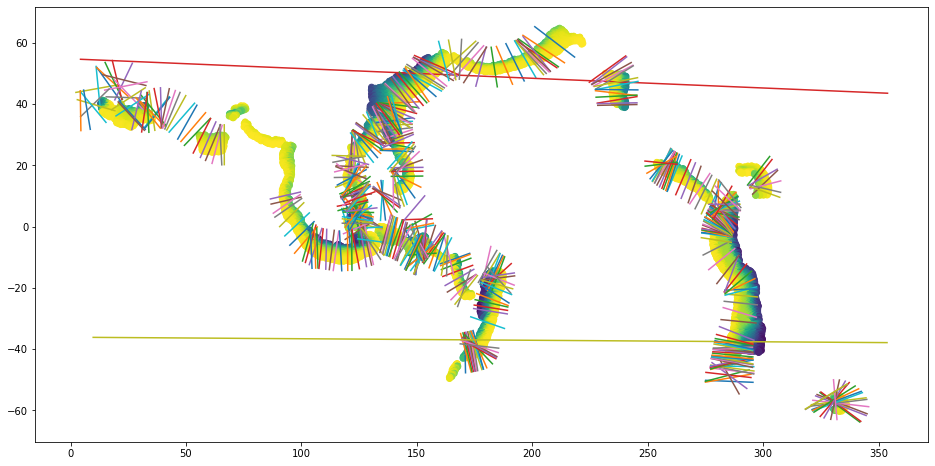

In [222]:
plt.figure(figsize=(16,8))
plt.scatter(df_new['lon'][::100], df_new['lat'][::100], c=df_new['depth'][::100])
plt.plot([cross_section_start_point[:,1], cross_section_end_point[:,1]],
         [cross_section_start_point[:,0],cross_section_end_point[:,0]])

In [22]:
variable = [] #peridotite
intersecting_points = []
intersecting_depths = []
intersecting_cross_sections_index = []
nan_cross_section = []
sub_zone_names = []
new_sub_length = []
tracks = []
for ind, points in enumerate(cross_section_points):
    for sub_zone in subduction_zones:
    #print(ind, sub_zone.title)
    
        grid = sub_zone.depth
        grid_uncertainty = sub_zone.depth_uncertainty
        ###main calculation, get data from cross sections

        # Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
        track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')
        #print(len(track))
        if len(track.index) == 0:
            continue
        if np.sum(track.depth) == 0.0:
            continue
        else:
            track_uncertain = pygmt.grdtrack(points=points, grid=grid_uncertainty, newcolname='depth_uncertainty')
            #the df will contain some NaNs that we want to filter
            track_dropna = track.dropna()
            track_uncertain_dropna = track_uncertain.dropna()
            #our data so far
            track_dropna['depth'] = track_dropna['depth'] * -0.001

            track_uncertain_dropna['depth_uncertainty'] = track_uncertain_dropna['depth_uncertainty'] * 0.001
            #get points intersecting the cross section from slab 2.0
            intersecting_points_reversed, intersecting_points_UNUSED, interpolated_variables, interpolated_depths = slab_workflow.get_intersecting_values(intersecting_lines[ind],
                                                                        cross_section_lines[ind])
            
            if not interpolated_variables:
                continue
            variable.append(interpolated_variables)
            print(ind, len(track.index))#, interpolated_depths[-1])

            intersecting_points.append(intersecting_points_reversed)
            intersecting_depths.append(interpolated_depths)
            intersecting_cross_sections_index.append(ind)
            sub_zone_names.append(sub_zone.title)
            new_sub_length.append(sub_length[ind])
            tracks.append(track_dropna)
            #print(ind)
            break

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 200
1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
14 200
15 200
16 200
17 200
18 197
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 193
35 198
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 167
46 171
47 169
48 171
49 171
50 142
51 142
52 146
53 148
54 149
55 151
56 152
57 153
58 156
59 159
60 160
61 164
62 182
63 200
64 200
65 200
66 200
67 197
69 200
70 193
71 192
72 192
73 188
74 193
75 195
76 192
77 184
78 179
79 177
80 118
81 200
82 200
83 200
84 200
85 156
86 138
87 75
88 77
89 75
90 77
91 81
92 91
93 99
94 115
95 122
96 115
97 200
98 200
99 200
100 200
101 200
102 185
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
119 149
120 144
121 182
133 159
134 180
135 195
136 199
137 198
138 196
147 139
148 144
149 153
150 175
151 141
152 133
153 133
154 133
155 135
156 146
157 171
158 187
159 200
160 186
161

In [23]:
distances = []
cum_distances = []
distance_range = []

for index, point in enumerate(intersecting_points):
    #calculate distance as going across cross section
    tmp_distances = []
    tmp_cum_distances = []
    for ind, i in enumerate(point):
        if ind == 0:
            #print(i[1])
            distance = 0
        else:
            #we need current point, and previous point to get the distance between
            #print(ind,i[1],intersecting_points[index][ind-1][1])
            distance = pygplates.GeometryOnSphere.distance(i[1], intersecting_points[index][ind-1][1])
        #print(distance)
        #to convert from radians to km we have to multiply by radius,
        #but as we are at depth, the radius is slightly different
#        print(intersecting_depths[index][::-1][0][ind])
        radius = pygplates.Earth.mean_radius_in_kms - intersecting_depths[index][::-1][ind]
        tmp_distances.append(distance*radius)
        tmp_cum_distances.append(np.sum(tmp_distances))
        #print(intersecting_depths[index][-1][::-1][ind], radius, distance, distance*radius)
    distances.append(tmp_distances)
    cum_distances.append(tmp_cum_distances)
    
    #use haversine formula to convert to km
    #get distance, equally spaced so we can define at the start
    lat1 = tracks[index]['lat'].values[0]
    lat2 = tracks[index]['lat'].values[1]
    lon1 = tracks[index]['lon'].values[0]
    lon2 = tracks[index]['lon'].values[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles

    distance = c*r

    #get the incremental range
    tmp_distance_range = []
    for i in range(track_dropna['depth'].count()):

        tmp_distance_range.append(i*distance)
        
    distance_range.append(tmp_distance_range)    

In [251]:
# Options for Model are:
#  - D80
#  - X25
#  - W1300
#  - T550
MODEL = 'T550'

SlabDir = '/Users/Andrew/Documents/PhD/Data/syracuse_thermal/Syracuse++_supp_Material/models/%s' % MODEL

files=[]
for(dirpath,dirnames,filenames) in walk(SlabDir):
    files.extend(filenames)
    break
files.sort()
#print f
arcs = []
for file in files:
    arcs.append(file.split('.')[0])
    
#slab surface | moho surface | slab curie depth | magnetite depth | moho curie depth
surface_arrays = []
isotherm_arrays = []
for j in np.arange(len(files)):

        FNAME = files[j]

        tmp_surface_arrays, tmp_isotherm_arrays = slab_workflow.get_slab_surfaces(SlabDir, FNAME)
        surface_arrays.append(tmp_surface_arrays)
        isotherm_arrays.append(tmp_isotherm_arrays)

        
#NB results are:
#surface (0 for top of slab, 7 for moho) | horiontal distance from trench | depth | temperature

In [252]:
closest_indices = []
closest_sub = []
thermal_data = []
for index in intersecting_cross_sections_index:
    print(index)
    input_lat = cross_section_start_point[index][0]
    input_lon = cross_section_start_point[index][1]
    
    #lol gotta take it back out
    if input_lon > 180:
        input_lon = input_lon-360
    #get closest based on lat
    df_sort = df_syracuse.iloc[(df_syracuse['Lat']-int(input_lat)).abs().argsort()[:10]]
    #now cross check for long
    df_closest = df_sort.iloc[(df_sort['Lon']-int(input_lon)).abs().argsort()[:1]]
    #print(df_closest['Name'])
    #to get index
    closest_index = df_closest.index.tolist()
    
    #index of closest will correspond to our slab surface database index
    index_of_closest = slab_workflow.find_with_list(arcs, df_closest['Name'].values[0])
    thermal_data_of_closest = surface_arrays[index_of_closest[0]]


    closest_indices.append(closest_index[0])
    closest_sub.append(df_closest)
    thermal_data.append(thermal_data_of_closest)

0
1
2
3
4
5
6
7
8
9
10
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
119
120
121
133
134
135
136
137
138
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
187
188
189
190
191
192
193
194
195
196
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
270
271
272
273
274
275
276
277
279
280
281
282
283
284
285
286
287
288
289
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314


In [253]:
def _find_nearest(array, value):
    """Find the index in array whose element is nearest to value.

    Parameters
    ----------
    array : np.array
      The array.

    value : number
      The value.

    Returns
    -------
    integer
      The index in array whose element is nearest to value.

    """
    if array.argmax() == array.size - 1 and value > array.max():
        return array.size
    return (np.abs(array - value)).argmin()

In [255]:
#here we map peridotite concentrations from our slab warping using the corrected depths
#to cross section depth from Slab2.0 (as the indices of interpolated depth and peridotite are the same)
#peridotite_content = []
#pressure = []
for ind, track_path in enumerate(tracks):
    #print(ind, track_path)
    #we want to use the depths from the slab 2.0 geometry as our 'base model'
    base_cross_section_depths = np.asarray(track_path['depth'])#thermal_data_of_cross_section[0][::,2]

    #get pressure
    local_pressure = []
    for X_depth in base_cross_section_depths:
        #pressure in GPa
        local_pressure.append(X_depth*9.8*3.3*1000*1000*1e-6*1e-3)
    #pressure.append(local_pressure)
    local_pressure = np.asarray(local_pressure)
    #interpolated depths to match to base cross section depth
    tmp_intersecting_depths = np.asarray(intersecting_depths[ind])
    ##get nearest indices
    vec_nearest = lambda x: _find_nearest(tmp_intersecting_depths, x)
    index_of_nearest_depth = np.vectorize(vec_nearest)(base_cross_section_depths)
#
    ##find peridotite values at index
    perid_at_depth = []
    for ind2,i in enumerate(index_of_nearest_depth):
        #print(i)
        perid = variable[ind][i]
#
        perid_at_depth.append(perid)

    perid_at_depth = np.asarray(perid_at_depth)
    #peridotite_content.append(perid_at_depth)
    
    #now for thermal data, [1] for slab moho, [0] for slab surface
    syracuse_depths = thermal_data[ind][1][::,2]
    syracuse_temps = thermal_data[ind][1][::,3]

    #get nearest indices
    vec_nearest_SYR = lambda x: _find_nearest(syracuse_depths, x)
    index_of_nearest_depth_SYR = np.vectorize(vec_nearest_SYR)(base_cross_section_depths)

    temp_at_depth = []
    for ind,i in enumerate(index_of_nearest_depth_SYR):
        if i == len(syracuse_depths):
            temperature = syracuse_temps[i-1]
        #print(i)
        else:
            temperature = syracuse_temps[i]

        temp_at_depth.append(temperature)

    temp_at_depth = np.asarray(temp_at_depth)

    #add to our dataframe
    track_path['pressure'] = local_pressure
    track_path['temp'] = temp_at_depth    
    track_path['peridotte'] = perid_at_depth    

In [256]:
final_sub_length = []
for ind, i in enumerate(intersecting_cross_sections_index):
    final_sub_length.append(sub_length[i])

In [257]:
len(final_sub_length)

413

In [267]:
target_temp = [400, 550]
target_pressure = [1, 4]

In [305]:
total_peridotite = []
total_h2 = []
relevant_tracks = []
for ind,a in enumerate(tracks):
    tmp_df =  a[(a['temp'] > target_temp[0])
             & (a['temp'] < target_temp[1])
             & (a['pressure'] > target_pressure[0])
             & (a['pressure'] < target_pressure[1])]
    if tmp_df.empty is False:
        print(sub_zone_names[ind])
        print(tmp_df)
        if len(tmp_df) == 1:
            #just assume 2 km spacing for now (will check later)
            perid_area = (2 * tmp_df['peridotte']).sum()
            
        else:
            perid_area = (tmp_df['depth'].diff() * tmp_df['peridotte']).sum()
        #print(tmp_df['peridotte'])
        actual_sub_length = final_sub_length[ind]
        total_peridotite.append(perid_area*actual_sub_length)
        total_h2.append(perid_area*actual_sub_length*perid_density_kg_km3*10e-2)
        relevant_tracks.append(tmp_df)
        tmp_df['sum_perid'] = sum(tmp_df['peridotte'])
    else:
        continue

Slab2 model - Zone: Alaska
            lon        lat      depth  pressure     temp  peridotte
121  207.845214  61.364157  80.946245  2.617802  454.206   0.353264
122  207.758586  61.413976  87.032261  2.814623  497.895   0.353264
123  207.671958  61.463796  93.586992  3.026603  532.825   0.353264
Slab2 model - Zone: Alaska
            lon        lat      depth  pressure     temp  peridotte
102  204.722166  58.067744  76.336169  2.468712  410.462   0.664949
103  204.631830  58.112735  81.637443  2.640155  461.340   0.654527
104  204.541494  58.157725  87.216788  2.820591  501.261   0.654527
105  204.451158  58.202716  93.085624  3.010389  532.825   0.654527
Slab2 model - Zone: Alaska
            lon        lat      depth  pressure     temp  peridotte
104  202.294212  56.895336  77.968933  2.521515  427.106   0.665037
105  202.207649  56.940688  82.684400  2.674013  468.982   0.665037
106  202.121086  56.986041  87.672810  2.835339  504.466   0.665037
107  202.034523  57.031393  92.9720

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume


           lon       lat       depth  pressure     temp  peridotte
39  124.536363  0.981767  123.457431  3.992613  430.824   0.353249
40  124.600892  0.971557  116.441823  3.765729  409.905   0.353249
85  127.504676  0.512110  115.495415  3.735122  404.237   0.353249
Slab2 model - Zone: Halmahera
           lon       lat       depth  pressure     temp  peridotte
26  123.597379 -0.625873  109.711247  3.548062  548.907   0.665241
27  123.662648 -0.623074  104.681042  3.385385  529.534   0.647901
28  123.727917 -0.620275   99.895750  3.230629  512.958   0.351741
29  123.793185 -0.617475   95.349934  3.083617  491.026   0.351741
30  123.858454 -0.614676   91.037844  2.944164  466.949   0.906423
31  123.923722 -0.611877   86.955160  2.812130  440.444   0.906423
32  123.988991 -0.609077   83.099871  2.687450  411.291   0.906423
80  127.121886 -0.474708   85.670240  2.770576  434.700   0.906423
81  127.187155 -0.471908   91.421201  2.956562  471.917   0.906423
82  127.252423 -0.469109   97.6

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume


Slab2 model - Zone: Makran
           lon        lat       depth  pressure     temp  peridotte
107  59.852375  28.800163  105.206123  3.402366  408.226   0.349281
108  59.886141  28.858392  108.327812  3.503321  417.538   0.349281
109  59.919907  28.916621  111.498340  3.605856  433.551   0.349281
110  59.953674  28.974850  114.714611  3.709871  448.362   0.349281
111  59.987440  29.033078  117.973843  3.815274  457.698   0.353263
112  60.021206  29.091307  121.274250  3.922009  471.013   0.353263
Slab2 model - Zone: Makran
           lon        lat       depth  pressure     temp  peridotte
123  62.483979  28.806161  104.225166  3.370642  403.733   0.666017
124  62.516472  28.864823  107.676613  3.482262  417.538   0.665591
125  62.548965  28.923484  111.127221  3.593854  433.551   0.665591
126  62.581458  28.982146  114.580625  3.705537  448.362   0.665591
127  62.613951  29.040808  118.042107  3.817482  457.698   0.665591
128  62.646444  29.099469  121.517651  3.929881  471.013   0.

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume


Slab2 model - Zone: Solomon Islands
           lon       lat       depth  pressure     temp  peridotte
90  155.229046 -6.205465  100.629456  3.254357  412.914   0.965908
91  155.254872 -6.145386  117.944840  3.814336  468.508   0.965908
Slab2 model - Zone: Kermadec
           lon        lat      depth  pressure     temp  peridotte
20  185.410658 -15.197506  86.045733  2.782719  509.308   0.351741
Slab2 model - Zone: Kermadec
           lon        lat      depth  pressure     temp  peridotte
42  185.629401 -15.688929  85.729185  2.772482  504.568   0.351741
Slab2 model - Zone: Halmahera
           lon       lat       depth  pressure     temp  peridotte
55  127.423078 -0.029064  104.891455  3.392190  529.534   0.719815
56  127.364451 -0.057964   98.616963  3.189273  504.405   0.719815
57  127.305825 -0.086863   92.827706  3.002048  476.807   0.719815
58  127.247198 -0.115763   87.498594  2.829705  446.013   0.719815
59  127.188571 -0.144662   82.604347  2.671425  411.291   0.719815
Slab

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Slab2 model - Zone: Manila Trench
          lon       lat       depth  pressure     temp  peridotte
37  120.63164  15.59394  115.617098  3.739057  404.237   1.102236
Slab2 model - Zone: Philippines
            lon        lat       depth  pressure     temp  peridotte
101  123.946402  12.851053  117.135233  3.788153  409.905   1.331697
Slab2 model - Zone: Manila Trench
           lon        lat       depth  pressure     temp  peridotte
23  121.462319  17.599381  118.930499  3.846212  415.422   0.552225
Slab2 model - Zone: Manila Trench
           lon        lat       depth  pressure     temp  peridotte
12  122.179449  19.277326  117.758661  3.808315  489.879   1.025886
13  122.111568  19.264843  110.165469  3.562751  461.288   1.025886
14  122.043686  19.252359  102.962220  3.329798  426.325   1.025886
Slab2 model - Zone: Manila Trench
           lon        lat       depth  pressure     temp  peridotte
17  121.772169  22.140367  108.569224  3.511129  455.988    0.55049
Slab2 model - Zone

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume


Slab2 model - Zone: South America
            lon        lat      depth  pressure     temp  peridotte
101  288.061966 -16.709628  76.236770  2.465497  402.115   0.665383
102  288.110780 -16.663916  79.928862  2.584899  447.150   0.665383
103  288.159594 -16.618204  83.581304  2.703019  487.205   0.665383
104  288.208408 -16.572492  87.194079  2.819857  519.800   0.665383
105  288.257222 -16.526780  90.769662  2.935491  546.478   0.665383
Slab2 model - Zone: South America
            lon        lat      depth  pressure     temp  peridotte
103  286.383608 -15.274651  77.978784  2.521834  422.368   0.353258
104  286.413027 -15.215768  79.772454  2.579841  447.150   0.348309
105  286.442446 -15.156885  81.364748  2.631336  466.225   0.348309
106  286.471865 -15.098001  82.764167  2.676593  479.165   0.348309
107  286.501285 -15.039118  83.981699  2.715968  492.115   0.348309
108  286.530704 -14.980235  85.030582  2.749889  500.723   0.348309
109  286.560123 -14.921351  85.926083  2.778850

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Slab2 model - Zone: South America
            lon       lat       depth  pressure     temp  peridotte
146  286.367011  7.263466   93.214816  3.014567  400.795   0.350357
147  286.429696  7.283163   95.990902  3.104346  410.883   0.350357
148  286.492380  7.302860   99.001970  3.201724  425.760   0.350357
149  286.555065  7.322557  102.264351  3.307229  436.700   0.350357
150  286.617750  7.342254  105.793780  3.421371  453.578   0.350357
151  286.680435  7.361951  109.606278  3.544667  469.466   0.350357
152  286.743120  7.381648  113.718229  3.677648  484.893   0.350357
153  286.805804  7.401346  118.144538  3.820794  495.472   0.350357
154  286.868489  7.421043  122.899416  3.974567  509.183   0.350357
Slab2 model - Zone: South America
            lon       lat       depth  pressure     temp  peridotte
154  286.482899  8.400595   92.751324  2.999578  400.795   0.349281
155  286.541904  8.429550   95.477008  3.087726  410.883   0.349281
156  286.600908  8.458504   98.399084  3.182226 

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume


Slab2 model - Zone: New Guinea
            lon       lat       depth  pressure     temp  peridotte
122  136.444301 -3.957896   83.395995  2.697026  417.019   0.666844
123  136.426247 -4.020694   87.182462  2.819481  446.013   0.666844
124  136.408193 -4.083492   90.920613  2.940373  466.949   0.666844
125  136.390139 -4.146289   94.593389  3.059150  486.368   0.666844
126  136.372085 -4.209087   98.199302  3.175765  504.405   0.639304
127  136.354031 -4.271885  101.752791  3.290685  521.329   0.639304
128  136.335977 -4.334683  105.284398  3.404897  533.517   0.665592
129  136.317923 -4.397481  108.835394  3.519737  545.144   0.665592
Slab2 model - Zone: New Guinea
            lon       lat       depth  pressure     temp  peridotte
120  137.000261 -3.998814   84.881537  2.745069  428.740   0.671622
121  136.978761 -4.060524   89.350901  2.889608  456.702   0.671622
122  136.957260 -4.122234   94.028243  3.040873  486.368   0.671622
123  136.935760 -4.183944   98.913560  3.198865  508.

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [311]:
tmp_df['lon'].values[0]

26.6303536543

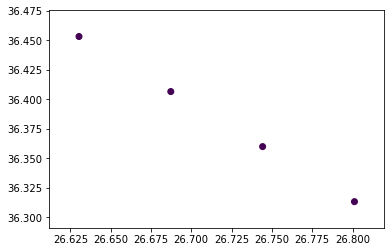

In [313]:
plt.scatter(tmp_df['lon'], tmp_df['lat'], c=tmp_df['sum_perid'])

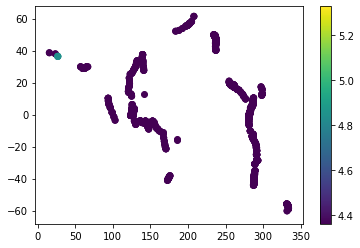

In [318]:
perid = []
for ind, i in enumerate(relevant_tracks):
    #print(i['peridotte'].values[0])
    plt.scatter(i['lon'], i['lat'], c=i['sum_perid'])
    perid.append(i['sum_perid'])
plt.colorbar()

([array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 4., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 4., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 4., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 4., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 5., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 4., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 5., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([ 0.,  0.,  0., 20.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([5., 0., 0., 0., 0., 0.,

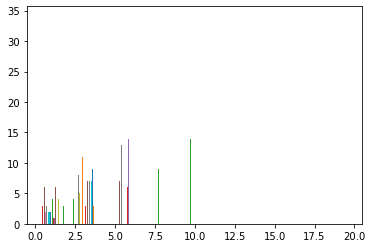

In [319]:
plt.hist(perid)

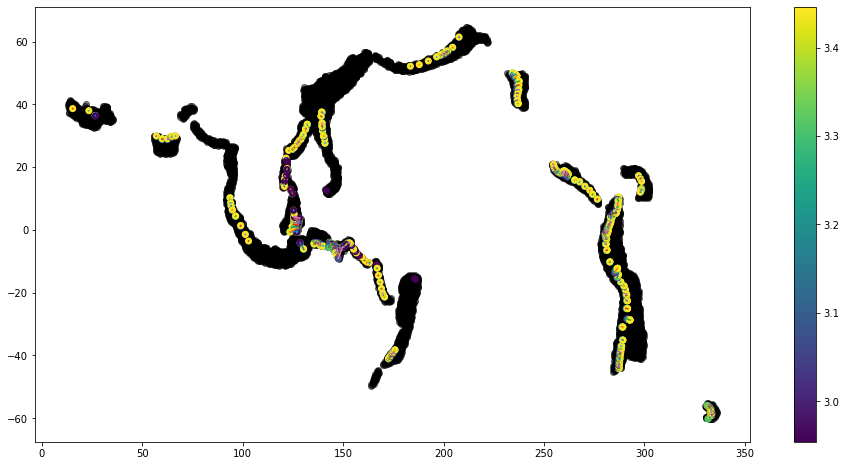

In [269]:
plt.figure(figsize=(16,8))
plt.scatter(df_new['lon'][::100], df_new['lat'][::100], c='k', alpha=0.5)
for i in relevant_tracks:
    plt.plot(i['lon'],i['lat'])
    plt.scatter(i['lon'],i['lat'], c=i['pressure'])
plt.colorbar()

In [270]:
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

In [271]:
water_react = perid_density_kg_km3 * np.sum(total_peridotite)

In [272]:
H2 = water_react * 10e-2

In [273]:
H2

7.094441739962682e+16

In [242]:
print('7.50e15', 'moles of H2')

7.50e15 moles of H2


In [223]:
tracks[0]

,lon,lat,depth,pressure,temp,peridotte
60,213.129525,58.325165,9.008338,0.291330,202.183,0.348309
61,213.042897,58.374984,9.633833,0.311558,202.183,0.348309
62,212.956269,58.424804,10.273853,0.332256,202.183,0.348309
63,212.869641,58.474623,10.912847,0.352921,202.183,0.347220
64,212.783012,58.524443,11.539743,0.373195,202.183,0.347220
...,...,...,...,...,...,...
128,207.238818,61.712893,134.942506,4.364041,620.578,0.350357
129,207.152190,61.762713,145.379541,4.701574,647.760,0.350357
130,207.065562,61.812532,156.724779,5.068479,672.880,0.350357
131,206.978934,61.862352,169.035597,5.466611,697.246,0.350357


In [ ]:
SurfaceArray_plot = surface_arrays[index_of_closest[0]][0]
MohoArray_plot = surface_arrays[index_of_closest[0]][1]

In [ ]:

fig, ax = plt.subplots(figsize=(6,10))

#ax.plot(SurfaceArray_plot[:,1],SurfaceArray_plot[:,2],'k',ls='--', zorder=2)
#ax.plot(MohoArray_plot[:,1],MohoArray_plot[:,2],'g',ls='-.', zorder=2)


scatter = ax.scatter(np.asarray(distance_range),
            track_dropna['depth'].values,c=perid_at_depth,s=temp_at_depth, cmap=plt.cm.viridis)
#plt.plot(np.asarray(distance_range),
#            track_dropna['depth'].values, lw=10)
ax.errorbar(np.asarray(distance_range),
            track_dropna['depth'].values,
            yerr=track_uncertain_dropna['depth_uncertainty'].values,
            alpha=0.2, zorder=1)
#plot = ax.scatter(SurfaceArray_plot[:,1]-7,SurfaceArray_plot[:,2],s=30,c=SurfaceArray_plot[:,3],\
#            cmap=plt.cm.gnuplot,edgecolor='none',vmin=100,vmax=800, zorder=2)
#ax.scatter(MohoArray_plot[:,1]-7,MohoArray_plot[:,2],s=30,c=MohoArray_plot[:,3],\
#            cmap=plt.cm.gnuplot,edgecolor='none',vmin=100,vmax=800, zorder=2)

#ax.scatter(np.asarray(cum_distances),
#            np.asarray(interpolated_depths[::-1]+10),
#           c='k')
#ax.plot(np.asarray(cum_distances),
#         np.asarray(interpolated_depths[::-1]+10), alpha=0.5, c='k')
#ax.plot(np.asarray(cum_distances),
#         np.asarray([i[2]+10 for i in intersecting_points_reversed]), alpha=0.5, c='b', ls='-.')


ax.set_xlabel('Distance From Trench (km)')
ax.set_ylabel('Depth (km)')
ax.set_xlim([0,600])
ax.set_ylim([0,150])
ax.invert_yaxis()
ax.set_title(files[index_of_closest[0]])

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Temperature")


cbar = fig.colorbar(scatter)
cbar.set_label('Perid (km)')
fig.tight_layout()
ax.grid()

#[left, bottom, width, height]


now we are just going to plot a few maps to show the context of what we are seeing

In [ ]:
#globe plotting
times = np.arange(0,1,1)
for time in times:
    raster_dir = '/Users/Andrew/Documents/PhD/Scripts/Scripts_Output/Chapman_2019/'
    raster_file = '%speridotite_thickness_post_serpentinisation%s_Ma.nc' % (raster_dir, time)
    #raster_file = '%sserpentinite_thickness_%s_Ma.nc' % (raster_dir, time)
    peridotite_grid = xr.open_dataset('%s' % raster_file)
    #plate data
    rotation_filename = '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS.rot'

    input_topology_filename = ['/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',
                               '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

    coastline_polygons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Coastlines/Matthews_etal_GPC_2016_Coastlines.gpmlz'
    isochrons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Isochrons/Muller_etal_AREPS_2016_Isochrons.gpmlz'
    COBs = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'


    #topology_features = pygplates.FeatureCollection(input_topology_filename)
    rotation_model = pygplates.RotationModel(rotation_filename)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
                           subplot_kw={'projection': ccrs.Orthographic(central_longitude=np.mean(lon),
                                                                       central_latitude=np.mean(lat))})
    data_crs = ccrs.Geodetic()
    poly_data_crs = ccrs.PlateCarree()
    date_line_wrapper = pygplates.DateLineWrapper(0)

    reconstructed_polygons = []
    reconstructed_isochrons = []
    reconstructed_COBs = []

    # Alternative method using 'partition_geometry'
    resolved_topologies = []
    shared_boundary_sections = []

    pygplates.resolve_topologies(input_topology_filename, rotation_model,
                                 resolved_topologies, int(time), shared_boundary_sections)


    pygplates.reconstruct(coastline_polygons,rotation_model, reconstructed_polygons, int(time))
    pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))
    pygplates.reconstruct(isochrons,rotation_model, reconstructed_isochrons, int(time))

    ax.plot([lon[0], lon[-1]],
            [lat[0], lat[-1]], transform=poly_data_crs, c='k',lw=5,zorder=3)

    for polygon in reconstructed_polygons:
        poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
        wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
        for wrapped_poly in wrapped_polys:
            wrapped_poly_lat = []
            wrapped_poly_lon = []
            for wrapped_poly_point in wrapped_poly.get_exterior_points():
                wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
                wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

            ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)

    for polygon in reconstructed_COBs:
        poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
        wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
        for wrapped_poly in wrapped_polys:
            wrapped_poly_lat = []
            wrapped_poly_lon = []
            for wrapped_poly_point in wrapped_poly.get_exterior_points():
                wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
                wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

            #ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
            ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='grey', alpha=0.5,
                    linewidth=1 ,zorder=0, transform=poly_data_crs)

    for shared_boundary_section in shared_boundary_sections:
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                            linewidth=3, alpha=0.5, zorder=1, transform=data_crs)

        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                            linewidth=3, alpha=0.5, zorder=1, transform=data_crs)                
        else:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                            linewidth=1, alpha=0.5, zorder=1, transform=data_crs)


    plot = ax.imshow(peridotite_grid['peridotite_thickness_post_serpentinisation'], origin='lower', transform=poly_data_crs, zorder=2)
    fig.colorbar(plot)
    #cbar.set_title('Peridotite (km)')
    #ax.set_global()
    ax.set_extent([120, 180, 20, 60])

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
#                       subplot_kw={'projection': ccrs.Orthographic(central_longitude=np.mean(lon),
#                                                                   central_latitude=np.mean(lat))})
#data_crs = ccrs.Geodetic()
#poly_data_crs = ccrs.PlateCarree()
#date_line_wrapper = pygplates.DateLineWrapper(0)
#
#reconstructed_polygons = []
#reconstructed_isochrons = []
#reconstructed_COBs = []
#
## Alternative method using 'partition_geometry'
#resolved_topologies = []
#shared_boundary_sections = []
#
#pygplates.resolve_topologies(input_topology_filename, rotation_model,
#                             resolved_topologies, int(time), shared_boundary_sections)
#
#
#pygplates.reconstruct(coastline_polygons,rotation_model, reconstructed_polygons, int(time))
#pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))
#pygplates.reconstruct(isochrons,rotation_model, reconstructed_isochrons, int(time))
#
#ax.plot([lon[0], lon[-1]],
#        [lat[0], lat[-1]], transform=poly_data_crs, c='k',lw=5,zorder=3)
#
#for polygon in reconstructed_polygons:
#    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
#    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
#    for wrapped_poly in wrapped_polys:
#        wrapped_poly_lat = []
#        wrapped_poly_lon = []
#        for wrapped_poly_point in wrapped_poly.get_exterior_points():
#            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
#            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())
#
#        ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
#    
#for polygon in reconstructed_COBs:
#    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
#    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
#    for wrapped_poly in wrapped_polys:
#        wrapped_poly_lat = []
#        wrapped_poly_lon = []
#        for wrapped_poly_point in wrapped_poly.get_exterior_points():
#            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
#            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())
#
#        #ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
#        ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='grey', alpha=0.5,
#                linewidth=1 ,zorder=0, transform=poly_data_crs)
#        
#for shared_boundary_section in shared_boundary_sections:
#    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
#        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
#            tmp = shared_sub_segment.get_resolved_geometry()
#            wrapped_polylines = date_line_wrapper.wrap(tmp)
#            for wrapped_polyline in wrapped_polylines:
#                mor_wrapped_point_lat = []
#                mor_wrapped_point_lon = []
#                for wrapped_point in wrapped_polyline.get_points():
#                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
#                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
#                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
#                        linewidth=3, alpha=0.5, zorder=1, transform=data_crs)
#                
#    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
#        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
#            tmp = shared_sub_segment.get_resolved_geometry()
#            wrapped_polylines = date_line_wrapper.wrap(tmp)
#            for wrapped_polyline in wrapped_polylines:
#                mor_wrapped_point_lat = []
#                mor_wrapped_point_lon = []
#                for wrapped_point in wrapped_polyline.get_points():
#                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
#                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
#                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
#                        linewidth=3, alpha=0.5, zorder=1, transform=data_crs)                
#    else:
#        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
#            tmp = shared_sub_segment.get_resolved_geometry()
#            wrapped_polylines = date_line_wrapper.wrap(tmp)
#            for wrapped_polyline in wrapped_polylines:
#                mor_wrapped_point_lat = []
#                mor_wrapped_point_lon = []
#                for wrapped_point in wrapped_polyline.get_points():
#                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
#                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
#                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
#                        linewidth=1, alpha=0.5, zorder=1, transform=data_crs)
#
#
#plot = ax.imshow(peridotite_grid['peridotite_thickness_post_serpentinisation'], origin='lower', transform=poly_data_crs, zorder=2)
#fig.colorbar(plot)
##cbar.set_title('Peridotite (km)')
##ax.set_global()
#ax.set_extent([100, 165, 0, 60])

In [ ]:
plt.figure(figsize=(6,10))
plt.scatter(np.asarray(cum_distances),
            np.asarray(interpolated_depths[::-1]) *-1,
           c=np.asarray(interpolated_variables))
plt.plot(np.asarray(cum_distances),
         np.asarray(interpolated_depths[::-1]) *-1, alpha=0.5, c='k')
plt.plot(np.asarray(cum_distances),
         np.asarray([i[2]*-1 for i in intersecting_points_reversed]), alpha=0.5, c='b', ls='-.')
plt.colorbar(label='cumaltive peridotite thickness (km)')
#plt.gca().set_xlim([0, 400])
#plt.gca().set_ylim([-200,0])
plt.xlabel('Distance from trench (km)')
plt.ylabel('Depth (km)')
plt.grid()